# Imports

In [ ]:
!pip install -q wandb

In [ ]:
import numpy as np
import pandas as pd

import json
import datetime
tz_ist = datetime.timezone(datetime.timedelta(hours=5, minutes=30))
timestr = lambda fmt:datetime.datetime.now(tz=tz_ist).strftime(fmt)

import tensorflow as tf
ks = tf.keras

import matplotlib.pyplot as plt

#import wandb

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

# Dataset Loading, Characteristic Extraction and Reshaping

In [ ]:
basepath = "/content/drive/MyDrive/Sem_8/dl-datasets/dakshina_dataset_v1.0/hi/lexicons"

col_names = ['Dev.','Roman','att.']
STARTCHAR = '\t'
ENDCHAR   = '\n'

def read_as_array(path):
  data = pd.read_csv(path, sep='\t', names=col_names).drop_duplicates(subset="Dev.").dropna()
  data['Dev.'] = STARTCHAR + data['Dev.'] + ENDCHAR
  return np.array(data)[:,:2]

train_data = read_as_array(basepath+"/hi.translit.sampled.train.tsv")
val_data   = read_as_array(basepath+"/hi.translit.sampled.dev.tsv")
test_data  = read_as_array(basepath+"/hi.translit.sampled.test.tsv")

In [ ]:
input_vocab = set()
target_vocab = set()

for i in range(len(train_data)):
  for char in train_data[i,1]:
    input_vocab.add(char)
  for char in train_data[i,0]:
    target_vocab.add(char)

input_vocab  = [''] + sorted(list(input_vocab))
target_vocab = [''] + sorted(list(target_vocab))

len_input_vocab  = len(input_vocab)
len_target_vocab = len(target_vocab)

input_dict  = dict([ (char, i) for i, char in enumerate(input_vocab)])
target_dict = dict([ (char, i) for i, char in enumerate(target_vocab)])

max_len_input  = max([ len(word) for data in [train_data[:,1], val_data[:,1], test_data[:,1]] for word in data ])
max_len_target = max([ len(word) for data in [train_data[:,0], val_data[:,0], test_data[:,0]] for word in data ])

In [ ]:
def str_to_numarray(strs, output_size, charmap):
  ret = np.zeros((len(strs), output_size), dtype="float32")
  for i, s in enumerate(strs):
    for j, ch in enumerate(s): ret[i,j] = charmap[ch]
  return ret

def vectorize_dataset(data):
  # inputs
  enc_inp = str_to_numarray(data[:,1], max_len_input, input_dict)
  dec_inp = str_to_numarray(data[:,0], max_len_target, target_dict)
  
  # targets
  dec_tgt = np.pad(dec_inp[:,1:],((0,0),(0,1)))
  dec_tgt_onehot = np.zeros((data.shape[0], max_len_target, len_target_vocab), dtype="float32")
  for i in range(len_target_vocab): dec_tgt_onehot[:,:,i] = dec_tgt[:,:]==i
  
  return enc_inp, dec_inp, dec_tgt_onehot

enc_inp_train, dec_inp_train, dec_tgt_train_onehot = vectorize_dataset(train_data)
enc_inp_val,   dec_inp_val,   dec_tgt_val_onehot   = vectorize_dataset(val_data)
enc_inp_test,  dec_inp_test,  dec_tgt_test_onehot  = vectorize_dataset(test_data)

# Functions

## Model Handling

In [ ]:
DEFAULT_NETPARAMS = {
    "embed_size": 16, 
    "latent_dim": 256, 
    "enc_layers": 1, 
    "dec_layers": 1, 
    "recurrent_cell": "SimpleRNN",
    "dec_attention": False,
    "dropout": 0, 
    "beam_size": 1, 
    "enc_state_dep": "first"
}

In [ ]:
def fresh_seq2seq_model(netparams):
  """
  Creates and returns a randomly initialized model for the given set of network parameters
  Input(s):
    netparams: dictionary-like object containing network parameters
  Output(s):
    training_model: keras.Model object initialised for the passed network parameters
  """

  # unpack network parameters
  embed_size = netparams["embed_size"]
  latent_dim = netparams["latent_dim"]
  enc_layers = netparams["enc_layers"]
  dec_layers = netparams["dec_layers"]
  exec("rlexec=ks.layers."+netparams["recurrent_cell"]); recurrent_cell = locals()["rlexec"]
  dec_attention = netparams["dec_attention"]
  dropout    = netparams["dropout"]
  enc_state_dep = netparams["enc_state_dep"]

  # encoder layers
  encoder_input = ks.Input(shape=(None,), name="encoder_input")
  encoder_embedding = ks.layers.Embedding(len_input_vocab+1, embed_size, mask_zero=True, name="encoder_embedding")
  encoder_rnns = [recurrent_cell(latent_dim, return_sequences=True, return_state=True, dropout=dropout, name="encoder_rnn_"+str(i)) for i in range(1,enc_layers+1)]

  # encoder feedforward path
  encoder_output = encoder_embedding(encoder_input)
  for encoder_rnn in encoder_rnns:
    encoder_ret = encoder_rnn(encoder_output)
    encoder_output, encoder_state = encoder_ret[0], list(encoder_ret[1:])

  # decoder layers
  decoder_input = ks.Input(shape=(None,), name="decoder_input")
  decoder_embedding = ks.layers.Embedding(len_target_vocab+1, embed_size, mask_zero=True, name="decoder_embedding")
  decoder_rnns = [recurrent_cell(latent_dim, return_sequences=True, return_state=True, dropout=dropout, name="decoder_rnn_"+str(i)) for i in range(1,dec_layers+1)]
  if dec_attention:
    decoder_attention = ks.layers.AdditiveAttention(name="decoder_attention")
    decoder_concat    = ks.layers.Concatenate(name="decoder_concat")
  decoder_dropout = ks.layers.Dropout(dropout, name="decoder_dropout")
  decoder_dense = ks.layers.Dense(len_target_vocab, activation="softmax", name="decoder_dense")

  # decoder feedforward path
  decoder_rnn_out = decoder_embedding(decoder_input)
  for i,decoder_rnn in enumerate(decoder_rnns):
    if enc_state_dep=='first':
      decoder_state_input = encoder_state if i==0 else None
    elif enc_state_dep=='all':
      decoder_state_input = encoder_state
    else:
      decoder_state_input = None
    decoder_ret = decoder_rnn(decoder_rnn_out, initial_state=decoder_state_input)
    decoder_rnn_out = decoder_ret[0]
  if dec_attention:
    context_vec, attn_weights = decoder_attention([decoder_rnn_out, encoder_output], return_attention_scores=True)
    decoder_dense_input = decoder_concat([decoder_rnn_out, context_vec])
  else:
    decoder_dense_input = decoder_rnn_out
  decoder_dense_input = decoder_dropout(decoder_dense_input, training=True)
  decoder_output = decoder_dense(decoder_dense_input)

  model = ks.Model([encoder_input, decoder_input], decoder_output, name="training_model")
  model.netparams = netparams
  return model

In [ ]:
def extract_inference_submodels(model):
  """
  Extracts and reconstructs encoder and decoder models and returns them
  Input(s):
    inference_model: keras.Model object to perform inference on
  Output(s):
    encoder_model: keras.Model object for encoder part of input model
    decoder_model: keras.Model object for decoder part of input model
  """
  # get layer from name
  layer_idxs = dict([(l.name,i) for i,l in enumerate(model.layers)])
  layer_from_name = lambda s: model.layers[layer_idxs[s]]
  
  # unpack network parameters
  netparams  = model.netparams
  latent_dim = netparams["latent_dim"]
  enc_layers = netparams["enc_layers"]
  dec_layers = netparams["dec_layers"]
  dec_attention = netparams["dec_attention"]
  recurrent_cell_name = netparams["recurrent_cell"]

  # reconstructing encoder model
    # inputs
  encoder_model_input = layer_from_name("encoder_input").input
    # outputs
  encoder_model_ret = layer_from_name("encoder_rnn_"+str(enc_layers)).output
  encoder_model_output, encoder_model_state_output = encoder_model_ret[0], list(encoder_model_ret[1:])
    # model reconstruction
  encoder_model = ks.Model(
    encoder_model_input, 
    [encoder_model_output, encoder_model_state_output], 
    name="encoder_model"
  )

  # reconstructing decoder model
    # inputs
  decoder_model_input  = layer_from_name("decoder_input").input
  decoder_model_encoder_output = ks.Input(shape=(max_len_input,latent_dim,), name="decoder_encoder_output")
  decoder_model_state_input  = []
    # outputs
  decoder_model_output = layer_from_name("decoder_embedding")(decoder_model_input)
  decoder_model_state_output = []
    # model reconstruction
  for dec_layer in range(1,dec_layers+1):
    decoder_model_state_input.append(
        [ks.Input(shape=(latent_dim,), name="decoder_state_h_"+str(dec_layer)), ks.Input(shape=(latent_dim,), name="decoder_state_c_"+str(dec_layer))] 
        if recurrent_cell_name=="LSTM" else [ks.Input(shape=(latent_dim,), name="decoder_state_"+str(dec_layer))]
    )
    decoder_ret = layer_from_name("decoder_rnn_"+str(dec_layer))(decoder_model_output, initial_state = decoder_model_state_input[-1])
    decoder_model_output, decoder_model_state = decoder_ret[0], list(decoder_ret[1:])
    decoder_model_state_output.append(decoder_model_state)
    dec_layer += 1
  if dec_attention:
    decoder_model_context_vec, decoder_model_attention_weights = layer_from_name("decoder_attention")([decoder_model_output, decoder_model_encoder_output], return_attention_scores=True)
    decoder_model_output = layer_from_name("decoder_concat")([decoder_model_output, decoder_model_context_vec])
  decoder_model_output = layer_from_name("decoder_dropout")(decoder_model_output, training=False)
  decoder_model_output = layer_from_name("decoder_dense")(decoder_model_output)
  if dec_attention:
    decoder_model = ks.Model(
      [decoder_model_input, decoder_model_encoder_output, decoder_model_state_input], 
      [decoder_model_output, decoder_model_state_output, decoder_model_attention_weights], 
      name="decoder_model"
    )
  else:
    decoder_model = ks.Model(
      [decoder_model_input, decoder_model_state_input], 
      [decoder_model_output, decoder_model_state_output], 
      name="decoder_model"
    )

  encoder_model.netparams = netparams
  decoder_model.netparams = netparams

  return encoder_model, decoder_model

## Sequence Inference

In [ ]:
def seq2seq(input_seq, models, **kwargs):
  """
  Performs the seq2seq operation using trained models
  Input(s):
    input_seq: input sequences to be transformed
    models: encoder and decoder models to be used
  Output(s):
    output_seq: transformed sequences
    attn_weights: attention weights; pass return_attention_weights=True to return
  """
  # Convert string input to numerical array
  encoded_input_seq = str_to_numarray(input_seq, max_len_input, input_dict)
  input_num = len(input_seq)

  # Unpack testing model and its network parameters
  encoder_model, decoder_model = models
  netparams = decoder_model.netparams
  latent_dim = netparams["latent_dim"]
  recurrent_cell_name = netparams["recurrent_cell"]
  dec_attention = netparams["dec_attention"]
  dec_layers = netparams["dec_layers"]
  enc_state_dep = netparams["enc_state_dep"]
  
  # Run encoder model and create initial state for decoder
  encoder_layer_out, encoder_states_out = encoder_model.predict(encoded_input_seq)
  default_initial_state = [np.zeros((input_num,latent_dim))]*(2 if recurrent_cell_name=="LSTM" else 1)
  if enc_state_dep=='first':
    decoder_state = [encoder_states_out] + [default_initial_state]*(dec_layers-1)
  elif enc_state_dep=='all':
    decoder_state = [encoder_states_out] * dec_layers
  else:
    decoder_state = [default_initial_state] * dec_layers

  # Sampling loop objects
  target_seq = np.repeat(target_dict[STARTCHAR],input_num)
  output_seq = ['']*input_num
  attn_weights_lst = []

  # Sampling loop for a batch of sequences
  for i in range(max_len_target):
    # Run decoder model to obtain output tokens data (and attention weights, if required)
    if dec_attention:
        output_tokens, decoder_state, attn_weights = decoder_model.predict([target_seq, encoder_layer_out, decoder_state])
        attn_weights_lst.append(attn_weights)
    else:
        output_tokens, decoder_state = decoder_model.predict([target_seq, decoder_state])

    # Sample a token for each output sequence
    sampled_token_index = np.argmax(output_tokens[:, -1, :],axis=1) ## BEAM SEARCH GOES HERE
    output_seq = list(map(lambda i:output_seq[i]+target_vocab[sampled_token_index[i]],range(input_num)))

    # Update the target sequences
    target_seq = np.array(sampled_token_index)
  
  # Remove extra characters (after first end character), and add start and end characters if requested
  startchar = ''
  if "add_startchar" in kwargs and kwargs["add_startchar"]==True:
    startchar = STARTCHAR
  endchar = ''
  if "add_endchar" in kwargs and kwargs["add_endchar"]==True:
    endchar = ENDCHAR
  output_seq = np.array(list(map(lambda s:startchar+s.split(ENDCHAR)[0]+endchar,output_seq)),dtype='str')
  
  # Return outputs (and attention weights, if required)
  if "return_attention_weights" in kwargs and kwargs["return_attention_weights"]==True:
    assert dec_attention, "ERROR: given model does not contain attention layer(s)"
    return output_seq, attn_weights_lst
  else:
    return output_seq

In [ ]:
def prediction_accuracy(data_pred, data_tgt):
  """
  Calculates and returns accuracy of prediction based on teacher forcing
  """
  assert len(data_pred)==len(data_tgt), "predicted and target data dimensions don't match"
  correct_pred = np.zeros(len(data_pred), dtype="int")
  
  correct_pred= data_pred==data_tgt

  return np.sum(correct_pred)/len(data_pred)

def transliterate_sentence(sentence, models):
  """
  Transliterates sentence (letters+spaces) for the given inference models
  Input(s):
    sentence: input sentence to be transliterated
    models: encoder and decoder models to be used
  Output(s):
    transliterated_sentence: transliterated output sentence
  """
  inwords = np.array(sentence.split(' '))
  outwords = seq2seq(inwords, inference_submodels)
  
  translated_sentence = ''
  for word in outwords: translated_sentence += word+' '
  
  return translated_sentence[:-1]

# Sample Runs

## Training a model for a particular network configuration

In [ ]:
# initialize training model
netparams = DEFAULT_NETPARAMS.copy()
netparams.update({
  "embed_size": 16, 
  "latent_dim": 256, 
  "enc_layers": 3, 
  "dec_layers": 2, 
  "recurrent_cell": "LSTM",
  "dec_attention": True,
  "dropout": 0.05, 
  "beam_size": 1, 
  "enc_state_dep": "first"
})
training_model = fresh_training_model(netparams) # ks.models.load_model(savedModelPath)
training_model.summary()

In [ ]:
# training parameters
epochs = 30
batch_size = 32

# compile training model
training_model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

# Create callbacks
wandb=True
patience=5

callbacks=[ks.callbacks.EarlyStopping(
  patience=patience,
  restore_best_weights=True
)]
if wandb:
  wandb.init(project="Dakshina HI Test 1")
  callbacks.append([wandb.keras.WandbCallback(monitor="val_accuracy")])

# train seq2seq model
training_model.fit(
    [enc_inp_train, dec_inp_train],
    dec_tgt_train_onehot,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=( [enc_inp_val, dec_inp_val], dec_tgt_val_onehot ),
    callbacks=callbacks
)

In [ ]:
training_model.evaluate(x=[enc_inp_test, dec_inp_test], y=dec_tgt_test_onehot)

In [ ]:
training_model.save("/content/drive/MyDrive/Sem_8/s2s_samplerun.h5")
json.dump(netparams, open("/content/drive/MyDrive/Sem_8/s2s_samplerun.json",'w'))

## Testing trained model

In [ ]:
use_trained_model = False
load_timestamp = "20210507_154802"

if use_trained_model:
  test_model = training_model
else:
  test_model = ks.models.load_model("/content/drive/MyDrive/Sem_8/trained-models/s2s_sweep_"+load_timestamp+".h5")
  test_model.netparams = json.load(open("/content/drive/MyDrive/Sem_8/trained-models/s2s_sweep_"+load_timestamp+".json",'r'))

In [ ]:
test_model.evaluate(x=[enc_inp_test, dec_inp_test], y=dec_tgt_test_onehot)

In [ ]:
encoder_model, decoder_model = gen_enc_dec_models(test_model)
encoder_model.summary()
decoder_model.summary()

In [ ]:
print(decode_sequence("rani", [encoder_model, decoder_model]))

# Training Sweep

In [ ]:
sweeplog_path = "/content/drive/MyDrive/Sem_8/sweep/sweeplog.txt"
savemodel_path = "/content/drive/MyDrive/Sem_8/sweep/trained-models"
run_sep = '-='*30+'-'

!mkdir -p $savemodel_path
!touch $sweeplog_path

In [ ]:
def runWandbSweep():
  wandb.init(project="dakshina_sweep")
  
  tcr_wandb_format     = timestr("%b %d '%y %H:%M")
  tcr_savemodel_format = timestr("%Y%m%d_%H%M%S")

  cfg = wandb.config
  netparams = DEFAULT_NETPARAMS.copy()
  netparams.update({
    "embed_size": cfg.embedding_size, 
    "latent_dim": cfg.hidden_layer_size,
    "enc_layers": cfg.num_encoder_layers,
    "dec_layers": cfg.num_decoder_layers,
    "recurrent_cell": cfg.a1_recurrent_cell,
    "dec_attention": cfg.decoder_attention,
    "dropout": cfg.dropout,
    "enc_state_dep": cfg.encoder_state_dependencies
  })
  
  log_output = "Sweep run created on "+tcr_wandb_format+" ("+tcr_savemodel_format+") with following sweep parameters:\n"
  for i,k in enumerate(netparams):
    log_output += str(i+1)+". "+k+" = "+str(netparams[k])+'\n'
  log_output += "\n\n"
  open(sweeplog_path,'a').write(log_output)
  
  model = fresh_training_model(netparams)
  model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
  
  model.fit(
      [enc_inp_train, dec_inp_train],
      dec_tgt_train_onehot,
      batch_size=cfg.batch_size,
      epochs=cfg.epochs,
      validation_data=( [enc_inp_val, dec_inp_val], dec_tgt_val_onehot ),
      callbacks=[
                  ks.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
                , wandb.keras.WandbCallback(monitor="val_accuracy")
                ]
  )

  model.save(savemodel_path+"/s2s_sweep_"+tcr_savemodel_format+".h5")
  json.dump(netparams, open(savemodel_path+"/s2s_sweep_"+tcr_savemodel_format+".json",'w'))
  open(sweeplog_path,'a').write("Sweep run completed, model saved with timestamp: "+tcr_savemodel_format+"\n\n"+run_sep+"\n\n")

In [ ]:
use_attention = True # False for Q2, True for Q5
wandbSweepCfg = {
  "name":"Dakshina Parameter Grid Sweep (xAttention)", 
  "metric":{
    "name":"val_accuracy",
    "goal":"maximize"
  }, 
  "method": "grid", 
  "parameters":{
    # network parameters
    "embedding_size": {"values":[128, 256]},
    "hidden_layer_size": {"values":[128, 256]},
    "num_encoder_layers": {"values":[1, 2]},
    "num_decoder_layers": {"values":[1]},
    "a1_recurrent_cell": {"values":["GRU", "LSTM", "SimpleRNN"]},
    "decoder_attention": {"values":[use_attention]},
    "dropout": {"values":[0.2, 0.4]},
    "encoder_state_dependencies":{"values":["first"]},
    
    # training parameters
    "epochs": { "values":[30] },
    "batch_size": { "values":[32] }
  }
}

open(sweeplog_path,'a').write(run_sep+"\n\nStarted sweep at "+timestr("%H:%M:%S on %b %d, %Y")+'\n\n')

sweepId = wandb.sweep(wandbSweepCfg)#"vasid99/uncategorized/uklnmska"
wandb.agent(sweepId, function = runWandbSweep)

# Testing with attention

In [ ]:
# initialize training model
netparams = DEFAULT_NETPARAMS.copy()
netparams.update({
  "embed_size": 64, 
  "latent_dim": 256, 
  "enc_layers": 1, 
  "dec_layers": 1, 
  "recurrent_cell": "LSTM",
  "dec_attention": True,
  "dropout": 0.2, 
  "beam_size": 1, 
  "enc_state_dep": "first"
})
training_model = fresh_training_model(netparams) # ks.models.load_model(savedModelPath)
#training_model.summary()


# training parameters
epochs = 30
batch_size = 32

# compile training model
training_model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

# Create callbacks
wandb=False
patience=5

callbacks=[ks.callbacks.EarlyStopping(
  patience=patience,
  restore_best_weights=True
)]
if wandb:
  wandb.init(project="Dakshina HI Test 1")
  callbacks.append([wandb.keras.WandbCallback(monitor="val_accuracy")])

# train seq2seq model
training_model.fit(
    [enc_inp_train, dec_inp_train],
    dec_tgt_train_onehot,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=( [enc_inp_val, dec_inp_val], dec_tgt_val_onehot ),
    callbacks=callbacks
)

In [ ]:
encoder_model, decoder_model = gen_enc_dec_models(training_model)
encoder_model.summary()
decoder_model.summary()

In [ ]:
seq_pred, attn_weights = decode_sequence("asambhav", [encoder_model, decoder_model])
seq_pred

In [ ]:
len(attn_weights)

In [ ]:
len(seq_pred)

In [ ]:
attn_weights[0].shape

In [ ]:
len_input = len('asambhav')

In [ ]:
attn_weights = np.array([ element[0,0,:len_input] for element in attn_weights ])
attn_weights.shape

In [ ]:
attn_weights

In [ ]:
plt.imshow(attn_weights, cmap='hot', interpolation='nearest')
plt.show()

# Inference on model with attention

In [ ]:
load_timestamp = "20210507_200906"# with attention: "20210507_200906"; without attention: "20210507_130939"
inference_model = ks.models.load_model("/content/drive/MyDrive/Sem_8/sweep_attn/trained-models/s2s_sweep_"+load_timestamp+".h5")
inference_model.netparams = json.load(open("/content/drive/MyDrive/Sem_8/sweep_attn/trained-models/s2s_sweep_"+load_timestamp+".json",'r'))

In [ ]:
print("INFERENCE MODEL")
inference_model.summary()
ks.utils.plot_model(inference_model)

In [ ]:
inference_model.evaluate(x=[enc_inp_test, dec_inp_test], y=dec_tgt_test_onehot)

In [ ]:
encoder_model, decoder_model = extract_inference_submodels(inference_model)
inference_submodels = [encoder_model, decoder_model]

In [ ]:
datamask = range(len(test_data))
if inference_model.netparams["dec_attention"]:
  test_pred, attn_weights_lst = seq2seq(test_data[datamask,1], inference_submodels, return_attention_weights=True, add_startchar=True, add_endchar=True)
else:
  test_pred = seq2seq(test_data[datamask,1], inference_submodels, add_startchar=True, add_endchar=True)

acc = prediction_accuracy(test_pred, test_data[datamask,0])
print("Prediction accuracy on test dataset = ",acc)

In [ ]:
test_df = pd.DataFrame(list(zip(test_data[:,1], test_data[:,0], test_pred)), columns=['Input', 'Actual', 'Predicted'])
test_df.head()

,Input,Actual,Predicted
0,ank,\tअंक\n,\tअंक\n
1,ankit,\tअंकित\n,\tअंकित\n
2,anakon,\tअंकों\n,\tअनाकों\n
3,angkor,\tअंकोर\n,\tअंगकर\n
4,angaarak,\tअंगारक\n,\tअंगारक\n


In [ ]:
test_df.to_csv("/content/drive/MyDrive/Sem_8/test_df.csv",index=False)

In [ ]:
attn_weights_arr = np.squeeze(np.array(attn_weights_lst))
attn_weights_arr = np.array([ attn_weights_arr[:,i,:] for i in range(attn_weights_arr.shape[1]) ])
attn_weights_arr.shape

(2500, 21, 20)

In [ ]:
from matplotlib.font_manager import FontProperties

font_prop = FontProperties(fname="/content/drive/MyDrive/Sem_8/Akshar_Unicode.ttf", size=18)

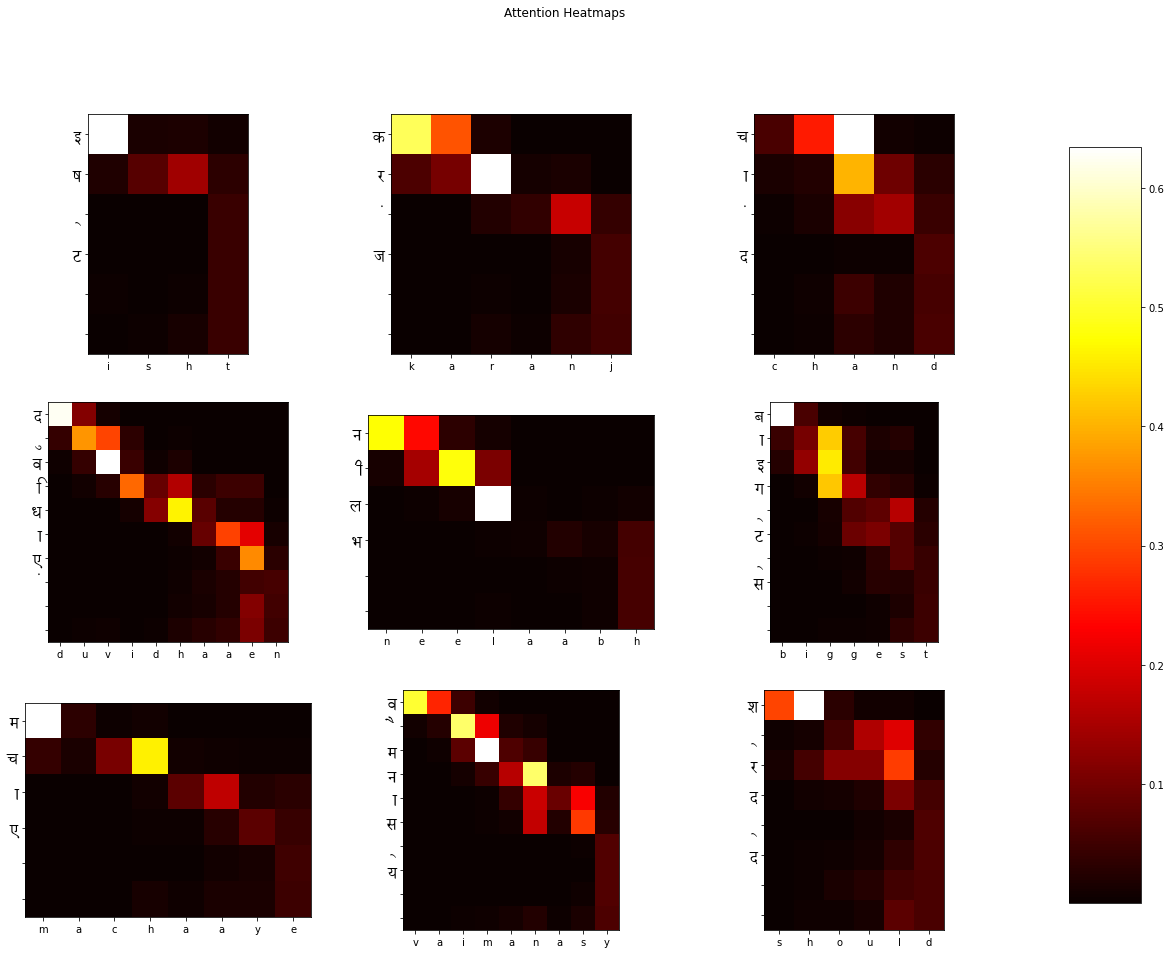

In [ ]:
ids_sub = np.sort(np.random.randint(len(test_pred), size=9))
test_in_sub = test_data[ids_sub, 1]
test_pred_sub = test_pred[ids_sub]
attn_weights_sub = attn_weights_arr[ids_sub]

fig, ax = plt.subplots(3, 3, figsize=(20,15))
fig.suptitle('Attention Heatmaps')
for i in range(9):
  pos = (i//3, i%3)
  input_word, len_in   = test_in_sub[i]  , len(test_in_sub[i])
  pred_word, len_pred  = test_pred_sub[i], len(test_pred_sub[i])
  attn_grid = attn_weights_sub[i][:len_pred, :len_in]
  xticks_ch = [ch for ch in input_word]
  yticks_ch = [ch for ch in pred_word[1:]]
  im = ax[pos].imshow(attn_grid, cmap='hot', interpolation='nearest')
  ax[pos].set_xticks(range(len_in))
  ax[pos].set_yticks(range(len_pred))
  ax[pos].set_xticklabels(xticks_ch)
  ax[pos].set_yticklabels(yticks_ch, fontproperties=font_prop)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

In [ ]:
wandb.init(project="DL Assignment03 Transliteration")
wandb.log({"Attention Heatmaps": wandb.Image(fig)})

# Connectivity

In [ ]:
from IPython.display import HTML as html_print
from IPython.display import display

import matplotlib
import matplotlib.cm as cm

from time import sleep

from IPython.display import clear_output

In [ ]:
#Map values to rgba
def map_val_to_color(input_arr):
    minima = min(input_arr)
    maxima = max(input_arr)

    norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Greens)

    mapped_lst = []
    for v in input_arr:
        color_rgba = (np.array(mapper.to_rgba(v))*255).astype(int)
        mapped_lst.append('#{:02x}{:02x}{:02x}'.format(*color_rgba))
    return np.array(mapped_lst)

# get html element
def cstr(s, color='black'):
	if s == ' ':
		return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
	else:
		return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)

# print html
parse_color = lambda t:''.join([cstr(ti, color=ci) for ti,ci in t])
print_color = lambda t:display(html_print(parse_color(t)))

In [ ]:
wandb.init(project="A3 Connectivity")
html_full_log = "<center>"
numwords = 6

for id_word in np.random.randint([len(test_data)]*numwords):
  html_log = "<table><tr><th>Predicted Word</th><th> </th><th>Input Word</th></tr>"
  input_word, len_in   = test_data[id_word,1], len(test_data[id_word,1])
  pred_word, len_pred  = test_pred[id_word][1:-1]  , len(test_pred[id_word][1:-1])

  input_chars = np.array([ch for ch in input_word])
  pred_chars  = np.array([ch for ch in pred_word])
  for i in range(len_pred):
      color_vals_pred = np.zeros(len_pred)
      color_vals_pred[i] = 1

      color_vals_in = attn_weights_arr[id_word, i, :len_in]

      colors_mappd_pred = map_val_to_color(color_vals_pred)
      colors_mappd_in   = map_val_to_color(color_vals_in)

      char_color_lst_pred = list(zip(pred_chars, colors_mappd_pred))
      char_color_lst_in   = list(zip(input_chars, colors_mappd_in))

      html_log += '<tr><td>'+parse_color(char_color_lst_pred)+'</td><td> </td><td>'+parse_color(char_color_lst_in)+'</td></tr>'
  html_log += "</table>"
  html_full_log += html_log+"<br>"
html_full_log += "</center>"
wandb.log({"Connections":wandb.Html(html_full_log)})

In [ ]:
# Code to calculate gradient of output w.r.t. input, did not work properly
'''
encoder_model3, decoder_model3 = extract_inference_submodels_2(inference_model)
inference_submodels3 = [encoder_model3, decoder_model3]

id = np.random.randint(len(test_data))
X = tf.constant(str_to_numarray([test_data[id,1]], max_len_input, input_dict))

Y = numseq2numseq(X, inference_submodels3)


with tf.GradientTape() as t:
  t.watch(X)
  Y = numseq2numseq(X, inference_submodels_2)

dy_dx = np.absolute(t.jacobian(Y,X).numpy())
'''

# Comparing predictions with and without attention

In [ ]:
pred_attn = np.array(pd.read_csv("/content/drive/MyDrive/Sem_8/predictions_attention.csv"))[:,-1]
pred_no_attn = np.array(pd.read_csv("/content/drive/MyDrive/Sem_8/predictions_no_attention.csv"))[:,-1]

acc_attn = prediction_accuracy(pred_attn, test_data[:,0])
acc_no_attn = prediction_accuracy(pred_no_attn, test_data[:,0])

print("Prediction accuracy on test dataset without attention = ",acc_no_attn)
print("Prediction accuracy on test dataset with attention = ",acc_attn)

In [ ]:
ids_attn_corr_no_attn_incorr = (pred_attn==test_data[:,0])&(pred_no_attn!=test_data[:,0])
pred_attn_attn_corr_no_attn_incorr    = pred_attn[ids_attn_corr_no_attn_incorr]
pred_no_attn_attn_corr_no_attn_incorr = pred_no_attn[ids_attn_corr_no_attn_incorr]
target_attn_corr_no_attn_incorr       = test_data[ids_attn_corr_no_attn_incorr,0]

attn_corr_no_attn_incorr_df = pd.DataFrame(list(zip(target_attn_corr_no_attn_incorr,
                                                    pred_no_attn_attn_corr_no_attn_incorr,
                                                    pred_attn_attn_corr_no_attn_incorr)), 
                                           columns=['Actual', 'Prediction w/o Attention', 'Prediction w Attention'])

In [ ]:
attn_corr_no_attn_incorr_df.to_csv("/content/drive/MyDrive/Sem_8/Correct_w_attention_incorrect_wo_attention.csv",index=False)